In [1]:
# We can't just send raw images throw our convolutional neural network. First we need all the images to be the same size, and we will also greyscale them.
import cv2          # working with, mainly resizing, images
import numpy as np  # dealing with arrays
import os           # dealing with directories
from random import shuffle      # mixing up our currently ordered data that might lead our network astay in training
from tqdm import tqdm           # a nice pretty percentage bar for tasks.

TRAIN_DIR = 'C:/Users/anves5/Documents/Kaggle_Data/dogs_vs_cats/train'
TEST_DIR = 'C:/Users/anves5/Documents/Kaggle_Data/dogs_vs_cats/test'
IMG_SIZE = 50
LR = 1e-3

MODEL_NAME = 'dogsvscats-{}-{}-model'.format(LR, '2conv-basic') # just so we remember which saved model is which, sizes must match

In [2]:
# We convert the images and labels to array information that we can pass through the network.

# help function. Since the images are named dog.1 or cat.2 and so on, the names dog and cat can be split out, and then be converted to an array.
def label_img(img):
    word_label = img.split('.')[-3]
    # conversion to one-hot array [cat,dog]
    #                             [much cat, no dog]
    if word_label == 'cat' : return [1,0]
    #                             [no cat, very doggo]
    elif word_label == 'dog' : return [0,1]

# greyscaling and resizing the images and then putting the images into an array 
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR, img)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        training_data.append([np.array(img), np.array(label)])
    shuffle(training_data)
    np.save('training_data.npy', training_data)
    return training_data


def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR, img)
        img_num = img.split('.')[0]
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        testing_data.append([np.array(img), img_num])
    shuffle(testing_data)
    np.save('testing_data.npy', testing_data)
    return testing_data


In [3]:
# If problems arise with model.fit in a later cell, then it can possibly be fixed by clearing the tensorflow session, with the folowing to lines.  As the error "You must feed a value for placeholder tensor 'target/Y' with dtype float and shape [?,2]" may occure.
#import keras.backend as K
#K.clear_session()

# If the data_set isn't already created
#train_data = create_train_data()

# If the data_set is already created:
train_data = np.load('training_data.npy', allow_pickle=True)

In [21]:
# reset the graph instance, since we're doing this in a continuous environment
import tensorflow as tf
tf.reset_default_graph()

In [22]:
# -----Defining the neural network-----
# A 2 layered convolutional neural network, with a fully connected layer, and an output layer.

import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')


# Load the model if we have one saved. Instead of creating a new one every time.
if os.path.exists('c:/Users/anves5/Documents/VsCode/Machinelearning_Eksamen/MachineLearning/'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

# Splitting the testing and training data
train = train_data[:-500]
test = train_data[-500:]

# Create our data arrays
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

# Fitting for 3 epochs
model.fit({'input': X}, {'targets': Y}, n_epoch=3, validation_set=({'input': test_x}, {'targets': test_y}), snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 4595  | total loss: 0.28161 | time: 39.190s
| Adam | epoch: 003 | loss: 0.28161 - acc: 0.8789 -- iter: 24448/24500
Training Step: 4596  | total loss: 0.27671 | time: 40.298s
| Adam | epoch: 003 | loss: 0.27671 - acc: 0.8832 | val_loss: 0.59747 - val_acc: 0.7400 -- iter: 24500/24500
--


In [6]:
# Save the MODEL_NAME so it can be used again, instead of creating it again.
# replace in the previous cell the path with the path created by the following save function, if you not already have.
model.save(MODEL_NAME)

INFO:tensorflow:C:\Users\anves5\Documents\VsCode\Machinelearning_Eksamen\MachineLearning\dogsvscats-0.001-2conv-basic-model is not in all_model_checkpoint_paths. Manually adding it.


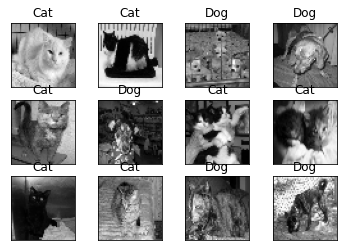

In [18]:
# preparing to visually inspect our neural network
import matplotlib.pyplot as plt

# if you need to create the data:
#test_data = process_test_data()
# if you already have some saved:
test_data = np.load('testing_data.npy', allow_pickle=True)

fig=plt.figure()

# Testing the Neural Network and in the end visually inspects it
for num,data in enumerate(test_data[:12]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)    # the +1 is because subplot starts at 1 while the array starts at 0.
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig, cmap='gray')
    plt.title(str_label)
    
    # Removes the axis since we don't want to see them
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()